**Exercise 1**: 

(a) Reduce the "ZIP-code"-dataset to two dimensions using Oja’s algorithm and plot thepoint cloud of the data set highlighting each class.

(b) Try one of the previously implemented classifiers (k-NN or Logistic Regression) on thetwo-dimensional dataset.

In [1]:
![ -e 'zip.train' ] || ( wget https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.train.gz && gzip -d zip.train.gz )
![ -e 'zip.test' ] || ( wget https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.test.gz && gzip -d zip.test.gz )

--2020-12-14 04:37:33--  https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.train.gz
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200, 2607:f6d0:0:925a::ab43:d7c8
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1829071 (1.7M) [application/x-gzip]
Saving to: ‘zip.train.gz’

zip.train.gz        100%[===================>]   1.74M  1.56MB/s    in 1.1s    

2020-12-14 04:37:34 (1.56 MB/s) - ‘zip.train.gz’ saved [1829071/1829071]

--2020-12-14 04:37:34--  https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.test.gz
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200, 2607:f6d0:0:925a::ab43:d7c8
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 439208 (429K) [application/x-gzip]
Saving to: ‘zip.test.gz’

zip.test.gz         100%[===================>] 428.91K   511KB/s    in

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
dirname = './'
path_to_train = dirname + 'zip.train'
path_to_test = dirname + 'zip.test'
training_data = np.array(pd.read_csv(path_to_train, sep=' ', header=None))
test_data = np.array(pd.read_csv(path_to_test, sep =' ',header=None))

X_train, y_train = training_data[:,1:-1], training_data[:,0]
X_test, y_test = test_data[:,1:], test_data[:,0]

In [4]:
from collections import Counter
from functools import wraps, partial


def collect_after(c):
  def decorator(f):
    @wraps(f)
    def g(*args, **kwargs):
      return c(f(*args, **kwargs))
    return g
  return decorator


class KNearestNeighbors():
    '''
    Think about defining more functions that will help you building this algorithm.
    Optimally, one that takes in k and a test image as a parameter.
    '''
    def squared_euclidean_distance(self, x_1, x_2, axis=1):
      '''
      np.sum(x, axis = 1) will be summing all elements over the pixel dimension (axis = 1)
      '''
      return np.sum((x_1 - x_2) ** 2, axis=axis)
    
    def set_k(self, k):
      self.k = k
    
    def __init__(self, k):
      self.set_k(k)
    
    def fit(self, X, y):
      self.X = X
      self.y = y
    
    @collect_after(tuple)
    def calculate_nearest(self, X, k=None):
      if k is None:
        k = self.k
      for obj in X:
        nearest = []
        for i, known in enumerate(self.X):
          d = self.squared_euclidean_distance(known, obj, axis=0)
          nearest.append((d, i))
          nearest.sort()
          nearest[k:] = []
        yield tuple(nearest)
    
    @collect_after(partial(np.fromiter, dtype=float))
    def predict_class(self, X, nearest=None):
      res = []
      k = self.k
      if nearest is None:
        nearest = self.calculate_nearest(X, k)
      for nearest_current in nearest:
        yield Counter(self.y[i] for _, i in nearest_current[:k]).most_common(1)[0][0]
    
    def predict_class_different_k(self, X, ks=(3,)):
      ks = tuple(ks)
      nearest = self.calculate_nearest(X, max(ks))
      for k in ks:
        self.set_k(k)
        yield (k, self.predict_class(X, nearest=nearest))


def accuracy(y_actual, y_pred):
  return (y_actual == y_pred).sum() / len(y_actual)

In [5]:
class OjaPCA():
  def __init__(self, gamma_0=1.0, gamma_ratio=0.5, iter_count=100):
    self.gamma_0 = gamma_0
    self.gamma_ratio = gamma_ratio
    self.iter_count = iter_count
    self.center = None
    self.W = None
    self.w = None  # For current iteration
    self.gamma = None
  
  def update_w(self, x):
    w = self.w
    sp = w.T @ x
    w += self.gamma * sp * (x - sp * w)
    norm = (w @ w) ** .5
    w /= norm
    self.w = w  # it's probably already inplace, but I'm not sure
  
  def proj_matrix(self, basis, preserve_basis=True):
    M = np.linalg.inv(basis.T @ basis) @ basis.T
    if preserve_basis:
      M = basis @ M
    return M

  def project_to(self, vecs, basis, preserve_basis=True):
    if len(basis.shape) < 2:
      basis = np.reshape(basis, (1, -1))
    if len(vecs.shape) < 2:
      vecs = np.reshape(vecs, (1, -1))
    p = self.proj_matrix(basis.T, preserve_basis)
    return (p @ vecs.T).T

  
  def fit(self, X, ndims=None):
    X = X.copy()
    if ndims is None:
      ndims = X.shape[1]
    self.center = np.mean(X, axis=0)
    X -= np.vstack((np.reshape(self.center, (1, -1)),) * X.shape[0])
    self.W = np.ndarray((ndims, X.shape[1]))
    for i in range(ndims):
      self.w = np.zeros((X.shape[1],)) 
      self.w[0] = 1
      self.gamma = self.gamma_0
      for _ in range(self.iter_count):
        if not self.gamma:
          break
        j = np.random.randint(X.shape[0])
        x = X[j]
        self.update_w(x)
        self.gamma *= self.gamma_ratio
      self.W[i] = self.w
      X -= self.project_to(X, self.w)
  
  def transform(self, X):
    X = X - np.vstack((np.reshape(self.center, (1, -1)),) * X.shape[0])
    return self.project_to(X, self.W, False)
  
  def fit_transform(self, X, ndims=None):
    self.fit(X, ndims)
    return self.transform(X)

In [6]:
def show_numbers(X, width, height):
    fig = plt.figure(figsize=(2 * width, 2 * height))

    for i in range(min(len(X), width * height)):
        ax = plt.subplot(height, width, i + 1)
        img = 1 - X[i].reshape((16, 16)) 
        plt.imshow(img, cmap='gray')
        plt.axis('off')

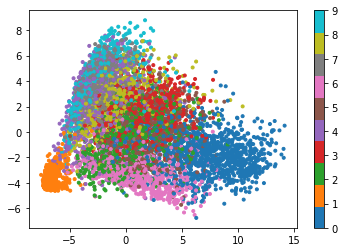

CPU times: user 972 ms, sys: 247 ms, total: 1.22 s
Wall time: 924 ms


In [7]:
%%time
np.random.seed(42)
oja = OjaPCA(2.0, 0.97, 3000)
X2dim = oja.fit_transform(X_train, 2)
plt.scatter(X2dim.T[0], X2dim.T[1], c=y_train, cmap='tab10', marker='.')
plt.colorbar(ticks=np.linspace(0, 9, 10))
plt.show()

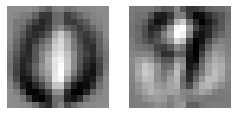

In [8]:
show_numbers(oja.W, 2, 1)

In [9]:
%%time
model = KNearestNeighbors(3)
model.fit(X2dim, y_train)
y_pred = model.predict_class(oja.transform(X_test))

CPU times: user 2min 1s, sys: 128 ms, total: 2min 2s
Wall time: 2min 2s


In [10]:
accuracy(y_test, y_pred)

0.4828101644245142

Two dimensions are probably not enough.

**Exercise 2**: 

Use your implementation of PCA on the greyscale-version of the "LFWcrop Face"-Dataset1.Visualize the first two principal components as Eigenfaces.

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
image_height: 50
image_width: 37
(5,)


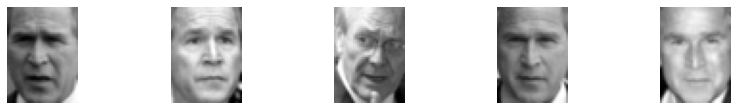

In [11]:
from sklearn.datasets import fetch_lfw_people
import numpy as np
from matplotlib import pyplot as plt


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print("image_height: %d" % h)
print("image_width: %d" % w)


def show_faces(X):
    num_samples = 5
    indices = np.random.choice(range(len(X)), num_samples)
    print(indices.shape)
    sample_digits = X[indices]

    fig = plt.figure(figsize=(20, 6))

    for i in range(num_samples):
        ax = plt.subplot(3, 7.5, i + 1)
        img = sample_digits[i].reshape((h, w))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
show_faces(X)

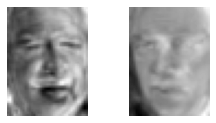

In [12]:
np.random.seed(123)
oja_faces = OjaPCA(200, .9, 1000)
oja_faces.fit(X, 2)
def show_all_faces(X, width, height):
    fig = plt.figure(figsize=(2 * width, 2 * height))

    for i in range(min(width * height, len(X))):
        ax = plt.subplot(height, width, i + 1)
        img = X[i].reshape((h, w))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
show_all_faces(oja_faces.W, 2, 1)